In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [6]:
reader = sitk.ImageFileReader()
reader.SetImageIO("TIFFImageIO")
reader.SetFileName('classic.tif')
img_T1 = reader.Execute();

In [17]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1]*2
    ysize = nda.shape[0]*2

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if(title):
        plt.title(title)

    plt.show()


def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05,
             dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))


    img_null = sitk.Image([0, 0], img.GetPixelID(),
                          img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i)
                                for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)

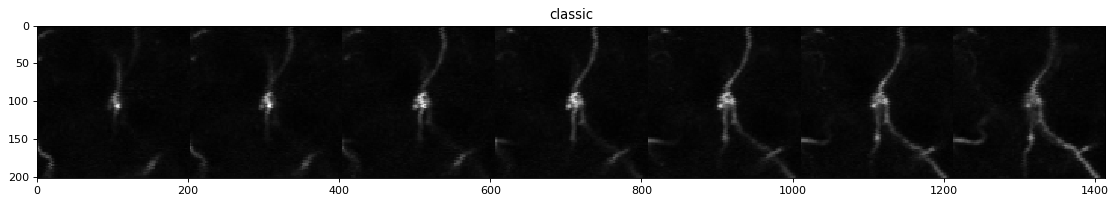

In [24]:
# To visualize the labels image in RGB needs a image with 0-255 range
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)

size = img_T1.GetSize()
myshow3d(img_T1_255, zslices=range(0, 7), title='classic')

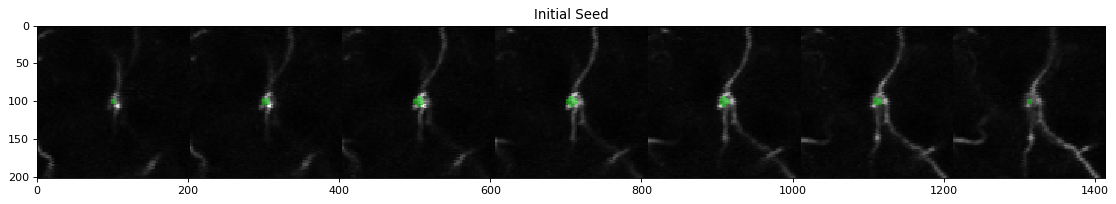

In [23]:
seed = (50,50,3)
seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, 3)

myshow3d(sitk.LabelOverlay(img_T1_255, seg),
         zslices=range(0,7), title="Initial Seed")

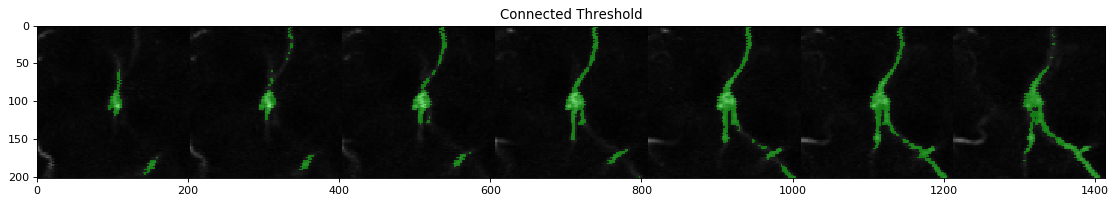

In [40]:
seg_con = sitk.ConnectedThreshold(img_T1_255, seedList=[seed],
                                  lower=35, upper=255)

myshow3d(sitk.LabelOverlay(img_T1_255, seg_con),
         zslices=range(0, 7), title="Connected Threshold")

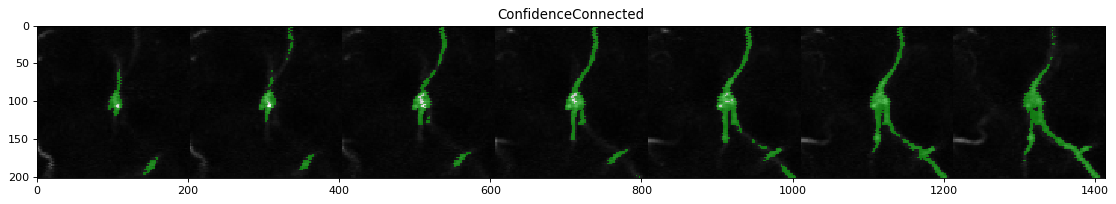

In [63]:
seg_conf = sitk.ConfidenceConnected(img_T1_255, seedList=[seed],
                                    numberOfIterations=1,
                                    multiplier=2,
                                    initialNeighborhoodRadius=1,
                                    replaceValue=1)

myshow3d(sitk.LabelOverlay(img_T1_255, seg_conf),
         zslices=range(0, 7), title="ConfidenceConnected")

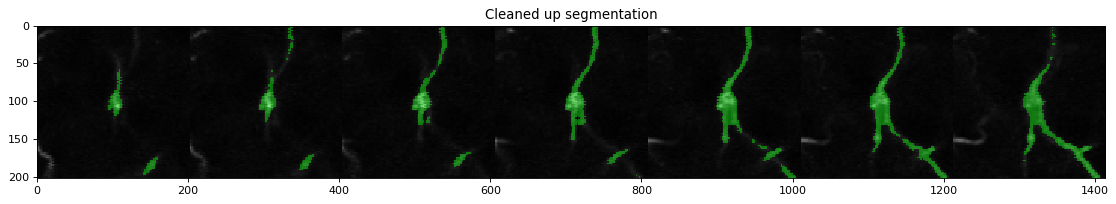

In [67]:
vectorRadius = (1, 1, 1)
kernel = sitk.sitkBall
seg_clean = sitk.BinaryMorphologicalClosing(seg_conf,
                                            vectorRadius,
                                            kernel)

myshow3d(sitk.LabelOverlay(img_T1_255, seg_clean),
         zslices=range(0, 7), title="Cleaned up segmentation")